# TEDx

Trying to classify TED talk's success based on characteristics of the talk and way audience perceives it.

In [0]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime
from textblob import TextBlob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import io
import seaborn as sns

## Ingestion

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

import os;os.listdir("/content/gdrive/My Drive/Colab Notebooks")
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d rounakbanik/ted-talks
!ls -l /content
!unzip /content/ted-talks.zip

ted-talks.zip: Skipping, found more recently modified local copy (use --force to force download)
total 47980
drwx------ 4 root root     4096 Feb  8 18:40 gdrive
drwxr-xr-x 1 root root     4096 Feb  6 17:31 sample_data
-rw-r--r-- 1 root root  7579795 Sep 25  2017 ted_main.csv
-rw-r--r-- 1 root root 13010715 Feb  8 18:40 ted-talks.zip
-rw-r--r-- 1 root root 28526129 Sep 25  2017 transcripts.csv
Archive:  /content/ted-talks.zip
replace ted_main.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ted_main.csv            
replace transcripts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: transcripts.csv         


In [0]:
df_ted = pd.read_csv("/content/ted_main.csv")
df_transcript = pd.read_csv('/content/transcripts.csv')

In [0]:
df_ted.head(3)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292


In [0]:
df_transcript.head(3)

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...


In [0]:
df_ted = pd.concat([df_ted.reset_index(drop = True), df_transcript], axis = 1)

In [0]:
df_ted.head(3)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript,url
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...


## Data Cleaning

In [0]:
df_ted.isna().sum()

comments               0
description            0
duration               0
event                  0
film_date              0
languages              0
main_speaker           0
name                   0
num_speaker            0
published_date         0
ratings                0
related_talks          0
speaker_occupation     6
tags                   0
title                  0
url                    0
views                  0
transcript            83
url                   83
dtype: int64

In [0]:
df_ted.loc[df_ted['languages'] == 0, 'languages'] = 1

In [0]:
df_ted.dropna(inplace = True)

## EDA and  Data manipulation

In [0]:
df_ted.describe()

,comments,duration,film_date,languages,num_speaker,published_date,views
count,2461.000000,2461.000000,2.461000e+03,2461.000000,2461.000000,2.461000e+03,2.461000e+03
mean,197.297440,829.987403,1.316230e+09,27.987810,1.026818,1.338108e+09,1.725872e+06
std,285.643456,377.693365,1.178084e+08,8.891478,0.193628,9.163422e+07,2.537288e+06
min,5.000000,135.000000,7.464960e+07,1.000000,1.000000,1.151367e+09,5.044300e+04
25%,68.000000,577.000000,1.257120e+09,23.000000,1.000000,1.266055e+09,7.645000e+05
50%,123.000000,855.000000,1.330474e+09,28.000000,1.000000,1.337182e+09,1.135382e+06
75%,226.000000,1054.000000,1.404778e+09,33.000000,1.000000,1.414163e+09,1.730653e+06
max,6404.000000,5256.000000,1.493078e+09,72.000000,4.000000,1.496418e+09,4.722711e+07


In [0]:
df_ted.drop(['main_speaker', 'related_talks', 'url', 'event'], axis = 1, inplace = True)

In [0]:
df_ted.head(3)

,comments,description,duration,film_date,languages,name,num_speaker,published_date,ratings,speaker_occupation,tags,title,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,1140825600,60,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,1140825600,43,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,1140739200,26,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."


### Creting  performance attributes

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


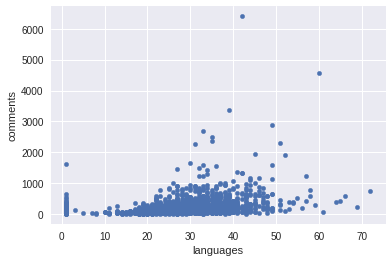

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


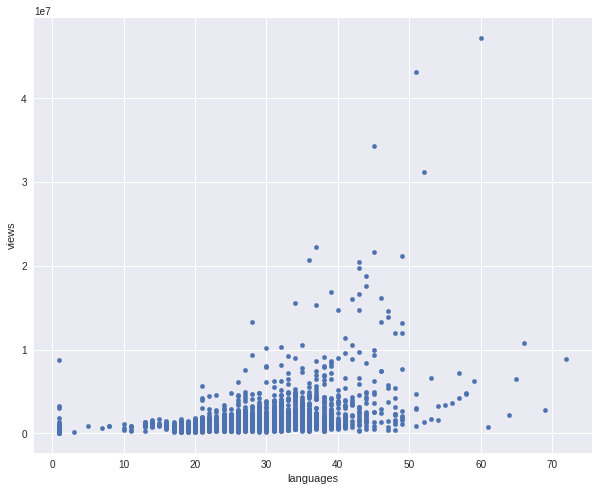

<Figure size 720x576 with 0 Axes>

In [0]:
#fig, axs = plt.subplots(1,2)
df_ted.plot.scatter(x = "languages", y = "comments")
plt.rcParams["figure.figsize"] = (10, 8)
plt.show()
plt.rcParams["figure.figsize"] = (10, 8)
df_ted.plot.scatter(x = "languages", y = "views")
plt.show()
plt.tight_layout()


In [0]:
df_ted['comments_per_language'] = df_ted.comments/ df_ted.languages
df_ted['views_per_language'] = df_ted.views/ df_ted.languages

In [0]:
df_ted.head(3)

,comments,description,duration,film_date,languages,name,num_speaker,published_date,ratings,speaker_occupation,tags,title,views,transcript,comments_per_language,views_per_language
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,1140825600,60,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,47227110,Good morning. How are you?(Laughter)It's been ...,75.883333,787118.500000
1,265,With the same humor and humanity he exuded in ...,977,1140825600,43,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,3200520,"Thank you so much, Chris. And it's truly a gre...",6.162791,74430.697674
2,124,New York Times columnist David Pogue takes aim...,1286,1140739200,26,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun...",4.769231,62934.307692


In [0]:
df_ted = df_ted.astype({'views_per_language': int}, copy = False)
df_ted = df_ted.astype({'comments_per_language': int}, copy = False)

In [0]:
df_ted.head(3)

,comments,description,duration,film_date,languages,name,num_speaker,published_date,ratings,speaker_occupation,tags,title,views,transcript,comments_per_language,views_per_language
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,1140825600,60,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,47227110,Good morning. How are you?(Laughter)It's been ...,75,787118
1,265,With the same humor and humanity he exuded in ...,977,1140825600,43,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,3200520,"Thank you so much, Chris. And it's truly a gre...",6,74430
2,124,New York Times columnist David Pogue takes aim...,1286,1140739200,26,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun...",4,62934


In [0]:
df_ted.drop(['comments', 'views', 'languages'], axis = 1, inplace = True)

In [0]:
df_ted.head(3)

,description,duration,film_date,name,num_speaker,published_date,ratings,speaker_occupation,tags,title,transcript,comments_per_language,views_per_language
0,Sir Ken Robinson makes an entertaining and pro...,1164,1140825600,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,Good morning. How are you?(Laughter)It's been ...,75,787118
1,With the same humor and humanity he exuded in ...,977,1140825600,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",6,74430
2,New York Times columnist David Pogue takes aim...,1286,1140739200,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,"(Music: ""The Sound of Silence,"" Simon & Garfun...",4,62934


### Creating topic attributes

In [0]:
list_of_tags = list(map(lambda x: x.replace('[','').replace(']','').replace('\'', '').split(','), df_ted.tags.values))

flattened_list_of_tags = reduce(lambda x, y: x+y, list_of_tags)

unique_tags = list(set(flattened_list_of_tags))
tag_frequency = list(map(lambda x: flattened_list_of_tags.count(x), unique_tags))
df_tag_frequency = pd.DataFrame({'tag': list(unique_tags), 'frequency': tag_frequency})

In [0]:
df_tag_frequency.head(3)

,frequency,tag
0,5,exoskeleton
1,29,feminism
2,115,art


In [0]:
df_tag_frequency.sort_values(by = ['frequency'], ascending = False, inplace = True)
df_tag_frequency['tag'] = df_tag_frequency[['tag']].apply(lambda x: x.str.strip())

In [0]:
df_tag_frequency.head(10)

,frequency,tag
407,704,technology
264,551,science
279,473,global issues
495,382,design
95,378,culture
85,307,TEDx
185,258,entertainment
124,221,health
464,215,innovation
349,200,society


In [0]:
df_tag_frequency_grouped = df_tag_frequency.groupby(['tag']).sum().reset_index().sort_values(by = ['frequency'], ascending = False)

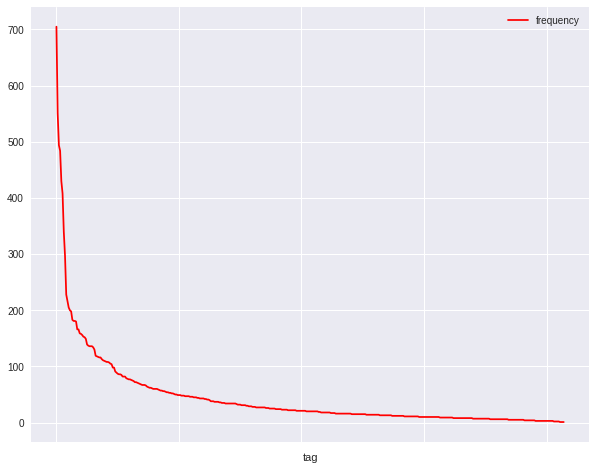

In [0]:
df_tag_frequency_grouped.plot.line(x = 'tag', y = 'frequency',c= 'red', figsize = (10,8))

In [0]:
df_tag_frequency_top_25 = df_tag_frequency_grouped.iloc[:25,:]

In [0]:
def assign_new_tags(old_tags):
    flag = 0
    for new_tags in list(df_tag_frequency_top_25.tag.values):
        if new_tags in old_tags:
            flag = 1
            break
        
    if flag == 1:
        return new_tags
    else:
        return 'others'    

In [0]:
df_ted['new_tags'] = list(map(lambda x: assign_new_tags(x) , list(df_ted.tags.values)))

In [0]:
df_ted.drop(['tags'], axis = 1, inplace = True)
df_ted['published_year'] = df_ted['published_date'].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y"))
df_ted.head(3)

,description,duration,film_date,name,num_speaker,published_date,ratings,speaker_occupation,title,transcript,comments_per_language,views_per_language,new_tags,published_year
0,Sir Ken Robinson makes an entertaining and pro...,1164,1140825600,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,Do schools kill creativity?,Good morning. How are you?(Laughter)It's been ...,75,787118,culture,2006
1,With the same humor and humanity he exuded in ...,977,1140825600,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",6,74430,technology,2006
2,New York Times columnist David Pogue takes aim...,1286,1140739200,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,Simplicity sells,"(Music: ""The Sound of Silence,"" Simon & Garfun...",4,62934,technology,2006


In [0]:

df_ted_grouped = df_ted.groupby(['published_year', 'new_tags']).size().reset_index()
df_ted_grouped.rename(columns = {0:"counts"},inplace = True)

In [0]:
df_ted.drop(['published_date', 'film_date'], axis = 1, inplace = True)

In [0]:
df_ted_grouped.head(3)

,published_year,new_tags,counts
0,2006,business,1
1,2006,culture,14
2,2006,entertainment,2


In [0]:
x = df_ted_grouped.published_year.values
y = df_ted_grouped.new_tags.values
z = df_ted_grouped.counts.values*10

### Create attributes for audience perception

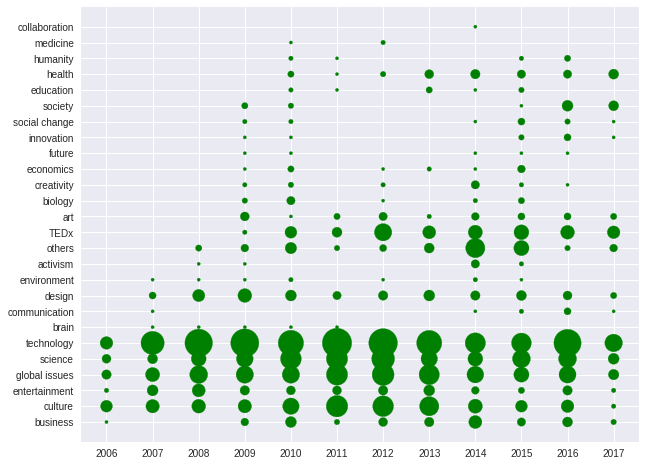

In [0]:
fig, ax = plt.subplots()
ax.scatter(x, y,c = 'g', s=z, cmap = 'jet_r')
plt.rcParams["figure.figsize"] = (30, 10)

plt.show()

In [0]:
df_ted['audience_rating_tag'] = df_ted['ratings'].apply(lambda x:x[x.find('name')+8: x.find('count')-4])

In [0]:
df_ted.head(5)

,description,duration,name,num_speaker,ratings,speaker_occupation,title,transcript,comments_per_language,views_per_language,new_tags,published_year,audience_rating_tag
0,Sir Ken Robinson makes an entertaining and pro...,1164,Ken Robinson: Do schools kill creativity?,1,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,Do schools kill creativity?,Good morning. How are you?(Laughter)It's been ...,75,787118,culture,2006,Funny
1,With the same humor and humanity he exuded in ...,977,Al Gore: Averting the climate crisis,1,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",6,74430,technology,2006,Funny
2,New York Times columnist David Pogue takes aim...,1286,David Pogue: Simplicity sells,1,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,Simplicity sells,"(Music: ""The Sound of Silence,"" Simon & Garfun...",4,62934,technology,2006,Funny
3,"In an emotionally charged talk, MacArthur-winn...",1116,Majora Carter: Greening the ghetto,1,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",Activist for environmental justice,Greening the ghetto,If you're here today — and I'm very happy that...,5,48501,business,2006,Courageous
4,You've never seen data presented like this. Wi...,1190,Hans Rosling: The best stats you've ever seen,1,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...",Global health expert; data visionary,The best stats you've ever seen,"About 10 years ago, I took on the task to teac...",12,250122,global issues,2006,Ingenious


In [0]:
df_ted['sentiment_polarity'] = (df_ted['description'].apply(lambda x: TextBlob(x).sentiment.polarity ) 
                                + df_ted['title'].apply(lambda x: TextBlob(x).sentiment.polarity ) 
                                + df_ted['transcript'].apply(lambda x: TextBlob(x).sentiment.polarity ))/3

df_ted['sentiment_subjectivity'] = (df_ted['description'].apply(lambda x: TextBlob(x).sentiment.subjectivity ) 
                                    + df_ted['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity ) 
                                    + df_ted['transcript'].apply(lambda x: TextBlob(x).sentiment.subjectivity ))/3

In [0]:
df_ted.head(3)

,description,duration,name,num_speaker,ratings,speaker_occupation,title,transcript,comments_per_language,views_per_language,new_tags,published_year,audience_rating_tag,sentiment_polarity,sentiment_subjectivity
0,Sir Ken Robinson makes an entertaining and pro...,1164,Ken Robinson: Do schools kill creativity?,1,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Author/educator,Do schools kill creativity?,Good morning. How are you?(Laughter)It's been ...,75,787118,culture,2006,Funny,0.146039,0.437350
1,With the same humor and humanity he exuded in ...,977,Al Gore: Averting the climate crisis,1,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",Climate advocate,Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",6,74430,technology,2006,Funny,0.013955,0.272996
2,New York Times columnist David Pogue takes aim...,1286,David Pogue: Simplicity sells,1,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",Technology columnist,Simplicity sells,"(Music: ""The Sound of Silence,"" Simon & Garfun...",4,62934,technology,2006,Funny,0.018199,0.407598


In [0]:
df_ted.drop(['description', 'name', 'num_speaker', 'ratings', 'speaker_occupation', 'transcript'], axis = 1, inplace = True)

In [0]:
df_ted.head()

,duration,title,comments_per_language,views_per_language,new_tags,published_year,audience_rating_tag,sentiment_polarity,sentiment_subjectivity
0,1164,Do schools kill creativity?,75,787118,culture,2006,Funny,0.146039,0.437350
1,977,Averting the climate crisis,6,74430,technology,2006,Funny,0.013955,0.272996
2,1286,Simplicity sells,4,62934,technology,2006,Funny,0.018199,0.407598
3,1116,Greening the ghetto,5,48501,business,2006,Courageous,0.027643,0.283888
4,1190,The best stats you've ever seen,12,250122,global issues,2006,Ingenious,0.365494,0.250210


## Modelling

In [0]:
corr= df_ted.corr()
corr

,duration,comments_per_language,views_per_language,sentiment_polarity,sentiment_subjectivity
duration,1.000000,0.069746,0.048333,-0.007017,-0.010674
comments_per_language,0.069746,1.000000,0.820924,0.016017,-0.011892
views_per_language,0.048333,0.820924,1.000000,0.031744,-0.000039
sentiment_polarity,-0.007017,0.016017,0.031744,1.000000,0.284094
sentiment_subjectivity,-0.010674,-0.011892,-0.000039,0.284094,1.000000


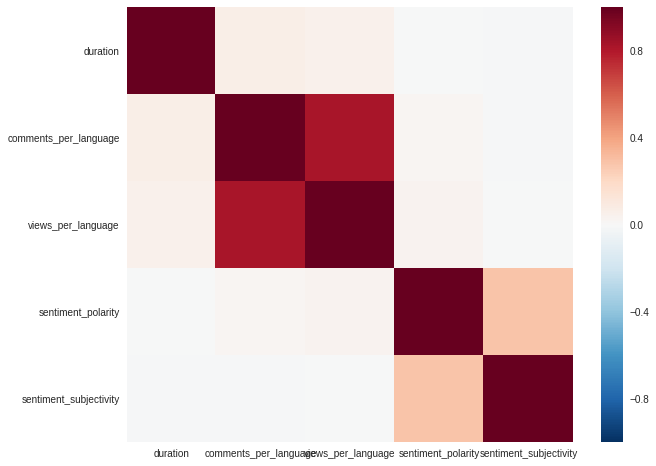

In [0]:
plt.rcParams["figure.figsize"] = (10, 8)
sns.heatmap(corr)

In [0]:
corr_variables = df_ted[['comments_per_language', 'views_per_language']].values

In [0]:
corr_variables = StandardScaler().fit_transform(corr_variables)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
corr_variables

array([[ 1.29400884e+00,  3.21408430e+00],
       [-1.18492428e-01, -3.10701125e-03],
       [-1.59434493e-01, -5.50018534e-02],
       ...,
       [-2.20847592e-01, -5.70241994e-02],
       [-2.20847592e-01,  1.95159635e-01],
       [-2.20847592e-01,  3.42341626e-02]])

In [0]:
pca = PCA(n_components=1)

principalComponents = pca.fit_transform(corr_variables)

In [0]:
df_ted['success'] = principalComponents

In [0]:
df_ted.head(3)

,duration,title,comments_per_language,views_per_language,new_tags,published_year,audience_rating_tag,sentiment_polarity,sentiment_subjectivity,success
0,1164,Do schools kill creativity?,75,787118,culture,2006,Funny,0.146039,0.437350,3.187703
1,977,Averting the climate crisis,6,74430,technology,2006,Funny,0.013955,0.272996,-0.085984
2,1286,Simplicity sells,4,62934,technology,2006,Funny,0.018199,0.407598,-0.151629


In [0]:
 df_ted_new = pd.concat([df_ted[['duration', 'sentiment_polarity', 'sentiment_subjectivity', 'published_year', 'success']].reset_index(drop = True), 
            pd.get_dummies(df_ted[['new_tags', 'audience_rating_tag']])], axis = 1)

In [0]:
df_ted_new.head()

,duration,sentiment_polarity,sentiment_subjectivity,published_year,success,new_tags_TEDx,new_tags_activism,new_tags_art,new_tags_biology,new_tags_brain,...,audience_rating_tag_Funny,audience_rating_tag_Informative,audience_rating_tag_Ingenious,audience_rating_tag_Inspiring,audience_rating_tag_Jaw-dropping,audience_rating_tag_Longwinded,audience_rating_tag_OK,audience_rating_tag_Obnoxious,audience_rating_tag_Persuasive,audience_rating_tag_Unconvincing
0,1164.0,0.146039,0.437350,2006,3.187703,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,977.0,0.013955,0.272996,2006,-0.085984,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1286.0,0.018199,0.407598,2006,-0.151629,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1116.0,0.027643,0.283888,2006,-0.183224,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1190.0,0.365494,0.250210,2006,0.561676,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_ted_new.dropna(inplace = True)

In [0]:
df_ted_new[['success']].quantile([0.25, 0.5, 0.75, 1.00])

,success
0.25,-0.266231
0.50,-0.200246
0.75,-0.084479
1.00,51.052931


In [0]:
def categorize_success(success):
    if success <= -0.266231:
        return 0
    elif success > -0.266231 and success<= -0.084479:
        return 1
    else:
        return 2

In [0]:
df_ted_new['success_category'] = df_ted_new['success'].apply(lambda x: categorize_success(x))

In [0]:
df_ted_new.head()

,duration,sentiment_polarity,sentiment_subjectivity,published_year,success,new_tags_TEDx,new_tags_activism,new_tags_art,new_tags_biology,new_tags_brain,...,audience_rating_tag_Informative,audience_rating_tag_Ingenious,audience_rating_tag_Inspiring,audience_rating_tag_Jaw-dropping,audience_rating_tag_Longwinded,audience_rating_tag_OK,audience_rating_tag_Obnoxious,audience_rating_tag_Persuasive,audience_rating_tag_Unconvincing,success_category
0,1164.0,0.146039,0.437350,2006,3.187703,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,977.0,0.013955,0.272996,2006,-0.085984,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1286.0,0.018199,0.407598,2006,-0.151629,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1116.0,0.027643,0.283888,2006,-0.183224,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1190.0,0.365494,0.250210,2006,0.561676,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


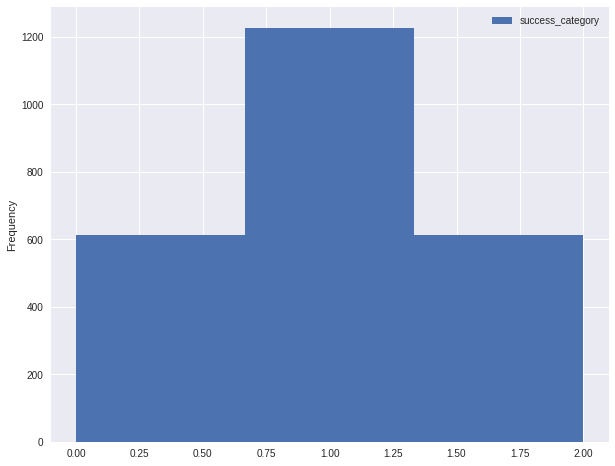

In [0]:
plt.rcParams["figure.figsize"] = (10, 8)

df_ted_new[['success_category']].plot.hist(bins = 3)

In [0]:
X = df_ted_new.drop(['success', 'success_category'], axis = 1)
y = df_ted_new[['success_category']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [0]:
def check_performace_with_tuning(n_est):
  rf_clf = RandomForestClassifier(n_estimators = n_est, max_features = 'auto')
  rf_clf.fit(X_train, y_train)
  y_pred = rf_clf.predict(X_test)
  return metrics.accuracy_score(y_test, y_pred)
                          

In [0]:
n_est = list(range(100, 2000, 50))

In [0]:
performance = list(map(lambda x: check_performace_with_tuning(x), n_est))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-v

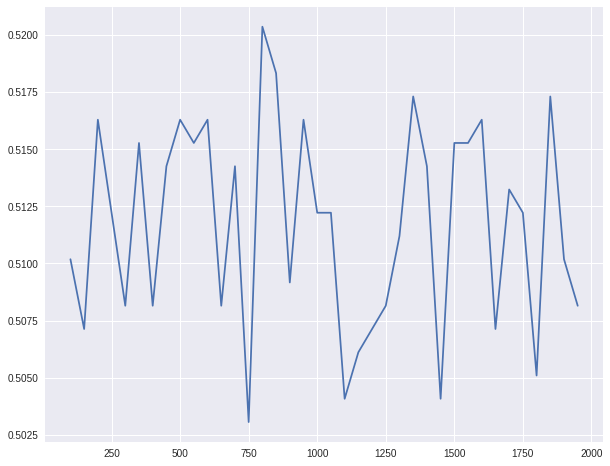

In [0]:
plt.plot(n_est, performance)

In [0]:
rf_clf = RandomForestClassifier(n_estimators = 500, max_features = 'auto')

In [0]:
rf_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
y_pred = rf_clf.predict(X_test)

In [0]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.5101832993890021

In [0]:
metrics.confusion_matrix(y_test,y_pred)

array([[ 72, 169,  23],
       [ 51, 390,  43],
       [ 25, 170,  39]])

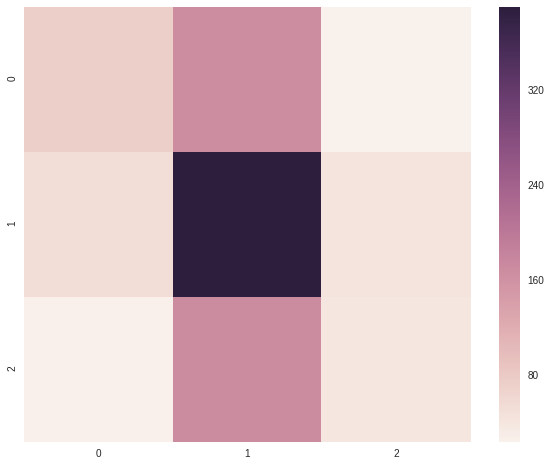

In [0]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred))

## Conclusion



*   Tuning n estimator can get accuracy only upto o51%. . Other parameters such as max features need to be explored
*   The model is predicting most of the vidoes in the "1" bucket. Bucket size needs to be changed or more buckets need to be added
* Tradeoff:
>* Increasing n estimate from 500 to 800 could make the accuracy better but increases the processing time as well so n = 500
>*  An increase in test data set makes the model better, however decreasing the train data set



